# Efficiency in forward and backward mode

The efficiency advantages of forward mode and backward mode can be explained in termes of jacobian - vector products or vector transpose - jacobian operations. Therefore, we showcase here a random matrix multiplication. We multiply two matrices and a vector. One time pushing through the matrix and one time pulling back the vector.

In [32]:
from time import time
A = np.random.random((5000, 5000))
B = np.random.random((5000, 5000))
v = np.random.random((5000, 1))

t_1 = time()
result = (A @ B) @ v
t_2 = time()
print('(A x B) x v  took', t_2-t_1, 'seconds')

t_1 = time()
result_2 = A @ (B @ v)
t_2 = time()
print(' A x (B x v) took', t_2-t_1, 'seconds')
print('Same result? -->', np.allclose(result,result_2))

(A x B) x v  took 1.4473445415496826 seconds
 A x (B x v) took 0.013015508651733398 seconds
Same result? --> True


Here we see that the operation including a matrix multiplication took roughly 170 times longer, for a size of 5000 while modern networks can be way bigger. The difference in results is due to machine precision.

# Nonlinear solve
Consider the simple nonlinear system of equations
$$\[
f_\theta(x,y) = \begin{pmatrix} x - y\\ e^x + \theta y \end{pmatrix} = \begin{pmatrix} 0\\ 0 \end{pmatrix}
\]$$
The solution cannot be expressed in closed form due to the exponential term. The first line has the trivial solution $x = y$. For $\theta > 0$, the second term of f is strictly monotonous and thus has an exact solution.

In [33]:
import autograd.numpy as np
from autograd import jacobian
from scipy import optimize
from scipy import linalg
import matplotlib.pyplot as plt

# define nonlinear function
def f(x,theta):
    return np.array([x[0] - x[1], np.exp(x[0]) + theta * x[1]])

# define loss criterion
def loss(y,y_true):
    return np.dot(y - y_true, (y - y_true).T)

# forward model (solve f(x) = 0)
def forward(theta,x0=np.array([0,0])):
    return optimize.root(f,x0,args=theta, method='hybr').x


Text(0.5, 0, 'x')

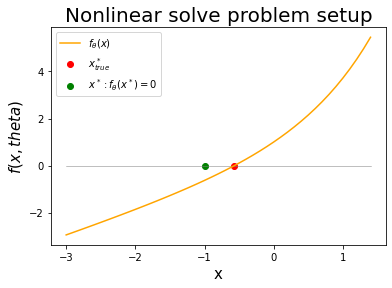

In [34]:
# define true solution and initialize theta
y_true = np.array([-1,-1])
theta = 1

# visualize system in x
x = np.arange(-3,1.5,0.1)
plt.plot(x,np.zeros_like(x),color='grey',linewidth=0.5)
plt.plot(x,f(np.stack([x,x]),theta)[1],label='$f_θ(x)$',color='orange')
plt.scatter(forward(theta)[1],0,color='r',label='$x^*_{true}$')
plt.scatter(y_true[1],0,color='g',label='$x^* : f_θ(x^*) = 0$')
plt.legend()
plt.title('Nonlinear solve problem setup',fontsize=20)
plt.ylabel('$f(x,theta)$',fontsize=15)
plt.xlabel('x',fontsize=15)

The task is to choose $\theta$ such that ${f_\theta}_2(y) = 0$ at $y = y_{true}$.

theta final =  0.36739991413826667


Text(0.5, 0, 'x')

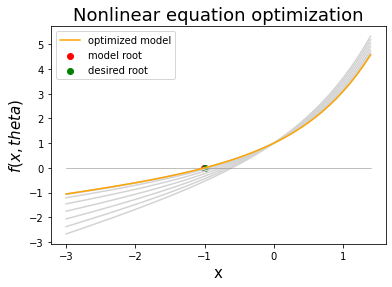

In [35]:
# calculate the total derivative dL/dθ

# these AD jacobians only needs to be defined once
df_dtheta = jacobian(f,argnum=1)
df_dx = jacobian(f,argnum=0)
dloss_dtheta = 0
dloss_dy = jacobian(loss,argnum=0)

########################## Main code #############################
def adjoint_model(y,y_true,theta):
    lmbd = linalg.solve(df_dx(y,theta).T,dloss_dy(y,y_true).T)
    return dloss_dtheta - lmbd.T @ df_dtheta(y,theta)
##################################################################

# optimize theta using gradient descent
theta = 1.0 # initialize
y = forward(theta)

while loss(y,y_true)>0.001:
    y = forward(theta)
    theta = theta - adjoint_model(y,y_true,theta) * 0.15
    plt.plot(x,f(np.stack([x,x]),theta)[1],color='lightgray')
print('theta final = ',theta)

# vizualize optimization process
plt.plot(x,np.zeros_like(x),color='grey',linewidth=0.5)
plt.plot(x,f(np.stack([x,x]),theta)[1],label='optimized model',color='orange')
plt.scatter(forward(theta)[1],0,color='r',label='model root')
plt.scatter(y_true[1],0,color='g',label='desired root')
plt.legend()
plt.title('Nonlinear equation optimization',fontsize=18)
plt.ylabel('$f(x,theta)$',fontsize=15)
plt.xlabel('x',fontsize=15)

# Adjoint state method for ODEs
<img src="Adjoint_State_Method_math.png" alt="image description" width="700" height="400">

The following example shows how the adjoint method works if it is build from scratch. For more practical implementations, see e.g. the DifferentialEquations.jl package in julia. In this example, it is also shown how a 'naive' finite difference approach is massively restricted in its accuracy by machine precision, while the adjoint state method is as accurate as the solver.
Consider an instructive little example:
$$ \dot{x} = f_\theta(x) = bx$$
$$ x(0) = a,\qquad \theta := (a,b)^T$$
$$ \mathcal{L} = \int_0^TL_\theta(x(t))\:dt = \int_0^T x \: dt$$

It is easily shown that the analytic solution is
$$ \frac{dL}{d\theta} = \begin{pmatrix} \frac{dL}{da}, & \frac{dL}{db} \end{pmatrix} = \begin{pmatrix} \frac{e^{bT} - 1}{b}, & \frac{a}{b}Te^{bT} - \frac{a}{b^2}(e^{bT} - 1) \end{pmatrix}$$

### The adjoint state method in action

In [61]:
from scipy.integrate import odeint
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import numpy as np
from time import time

# Define all variables, functions and partial derivatives
theta = np.random.rand(2) # = a,b
x0 = theta[0]
T = 2
dt = 0.1

def f(x,t,theta):
    return theta[1] * x

def L(x,theta):
    return x

def x0_del_theta(x,t,theta):
    return np.array([[1,0]])

def f_del_x(x,t,theta):
    return np.array([[theta[1]]])

def f_del_theta(x,t,theta):
    return np.array([[0, x]])

def L_del_x(x,t,theta):
    return np.array([[1]])

def L_del_theta(x,t,theta):
    return np.array([[0,0]])

def adjointODE(adjoint,t,x,theta):
    # x must be a function of t
    x = float(x(t))
    lambd = np.reshape(adjoint[0],(1,1))

    lambda_dot = - lambd.T @ f_del_x(x, t, theta) + L_del_x(x,t,theta)
    integrand = lambd.T @ f_del_theta(x, t, theta) + L_del_theta(x, t, theta) #∂/∂t(dL/dθ)
    return np.hstack((lambda_dot, integrand)).flatten()

def analytical_solution(theta,T):
    a = theta[0]
    b = theta[1]
    dL_da = (np.exp(b*T) - 1)/b
    dL_db = a / b * T * np.exp(b*T) - a / b**2 * (np.exp(b*T) - 1)
    return np.array([dL_da, dL_db])

### Start algorithm ###
t0 = time()

# Integrate x forward
x = odeint(f,x0,t=np.arange(0,T+dt,dt),args=(theta,))
x = interp1d(np.arange(0,T+dt,dt),x,kind='nearest',axis=0,bounds_error=False,fill_value='extrapolate')

# Integrate lambda_dot and loss integral backwards
adjT = np.array([0,0,0]) #  adjoint = (lam, integrand)
t = np.arange(T,0-dt,-dt)

adjoint  = odeint(adjointODE,adjT,t,args=(x,theta,))
dL_dtheta = - adjoint[-1:,0:1] @ x0_del_theta(x(0),0,theta) + adjoint[-1,1:]
t1 = time()

### analytical solution ###
anal = analytical_solution(theta,T)

print('∂/∂t(dL/dθ)')
print('Adjoint state method solution: {} ({}s)'.format(dL_dtheta.flatten(),np.round(t1-t0,3)))
print('Analytical solution:           {}'.format(anal))
print('______________________________________________________________________')
print('Difference:                    {}'.format(dL_dtheta.flatten() - anal))

∂/∂t(dL/dθ)
Adjoint state method solution: [5.88351567 1.79323588] (0.092s)
Analytical solution:           [5.88351338 1.79311915]
______________________________________________________________________
Difference:                    [2.29223883e-06 1.16730799e-04]


### 'Naive' finite differences

In [62]:
h = 1e-8
da = np.array([h, 0])
db = np.array([0, h])
t = np.arange(0,T+dt,dt)

def total_loss(t,theta):
    x0 = theta[0]
    x = odeint(f,x0,t=np.arange(0,T+dt,dt),args=(theta,))
    return np.sum(L(x,theta)) * dt

t0 = time()
dloss_da = (total_loss(t,theta + da) - total_loss(t,theta)) / da[0]
dloss_db = (total_loss(t,theta + db) - total_loss(t,theta)) / db[1]
t1 = time()

print('Finite differences solution: {} ({}s)'.format([dloss_da, dloss_db],np.round(t1-t0,3)))
print('Analytical solution:         {}'.format(anal))
print('______________________________________________________________________')
print('Difference:                  {}'.format(np.array([dloss_da, dloss_db]) - anal))

Finite differences solution: [6.2634019970531085, 1.9497863323891806] (0.001s)
Analytical solution:         [5.88351338 1.79311915]
______________________________________________________________________
Difference:                  [0.37988862 0.15666718]


The error is much higher in the finite difference case, because it is limited by machine precision (truncion error vs. rounding error). However in the 1D example, finite difference is still a lot faster than the (unoptimized) implementation of the adjoint state method. This is expected to change with high dimensions of $x$.